In [1]:
__depends__ = [
    "../../../data/database-results/phase-1/timestamp.txt",
    "../../../data/database-observations/timestamp.txt",
]
__dest__ = ["../../../figures/emulation-comparison-generic.pdf"]

In [2]:
EMULATION_COMPARISON_GENERIC_FIGURE_PDF = __dest__[0]

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Emulation ability

In [4]:
import datetime as dt
import glob
import logging
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import pyam
import tqdm

from pymagicc.io import MAGICCData
from scmdata import df_append, ScmDataFrame

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from utils import (
    clean_label,
    clean_labels,
    convert_scmdf_to_pyamdf_year_only,
    load_database_files,
    prep_str_for_filename,
)

<IPython.core.display.Javascript object>

In [6]:
logger = logging.getLogger()

<IPython.core.display.Javascript object>

In [7]:
color_map_scenarios_base = {
    "ssp119": "AR6-SSP1-1.9",
    "ssp126": "AR6-SSP1-2.6",
    "ssp245": "AR6-SSP2-4.5",
    "ssp370": "AR6-SSP3-7.0",
    "ssp370-lowNTCF": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-gidden": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-aerchemmip": "AR6-SSP3-LowNTCF",
    "ssp434": "AR6-SSP4-3.4",
    "ssp460": "AR6-SSP4-6.0",
    "ssp585": "AR6-SSP5-8.5",
    "ssp534-over": "AR6-SSP5-3.4-OS",
    "historical": "black",
    "rcp26": "AR5-RCP-2.6",
    "rcp45": "AR5-RCP-4.5",
    "rcp60": "AR5-RCP-6.0",
    "rcp85": "AR5-RCP-8.5",
    "historical-cmip5": "tab:gray",
    "1pctCO2": "tab:blue",
    "abrupt-4xCO2": "tab:red",
    "abrupt-2xCO2": "tab:orange",
    "abrupt-0p5xCO2": "tab:green",
}

color_map_scenarios = {}
for k, v in color_map_scenarios_base.items():
    color_map_scenarios[k] = v
    color_map_scenarios["esm-{}".format(k)] = v
    color_map_scenarios["esm-{}-allGHG".format(k)] = v

pyam.run_control().update({"color": {"scenario": color_map_scenarios}})

<IPython.core.display.Javascript object>

In [8]:
color_map_scenarios_hex = {}
for k, v in color_map_scenarios.items():
    try:
        color_map_scenarios_hex[k] = pyam.plotting.PYAM_COLORS[v]
    except KeyError:
        color_map_scenarios_hex[k] = v

color_map_scenarios_hex

{'ssp119': '#00AAD0',
 'esm-ssp119': '#00AAD0',
 'esm-ssp119-allGHG': '#00AAD0',
 'ssp126': '#003466',
 'esm-ssp126': '#003466',
 'esm-ssp126-allGHG': '#003466',
 'ssp245': '#EF550F',
 'esm-ssp245': '#EF550F',
 'esm-ssp245-allGHG': '#EF550F',
 'ssp370': '#E00000',
 'esm-ssp370': '#E00000',
 'esm-ssp370-allGHG': '#E00000',
 'ssp370-lowNTCF': '#E00000',
 'esm-ssp370-lowNTCF': '#E00000',
 'esm-ssp370-lowNTCF-allGHG': '#E00000',
 'ssp370-lowNTCF-gidden': '#E00000',
 'esm-ssp370-lowNTCF-gidden': '#E00000',
 'esm-ssp370-lowNTCF-gidden-allGHG': '#E00000',
 'ssp370-lowNTCF-aerchemmip': '#E00000',
 'esm-ssp370-lowNTCF-aerchemmip': '#E00000',
 'esm-ssp370-lowNTCF-aerchemmip-allGHG': '#E00000',
 'ssp434': '#FFA900',
 'esm-ssp434': '#FFA900',
 'esm-ssp434-allGHG': '#FFA900',
 'ssp460': '#C47900',
 'esm-ssp460': '#C47900',
 'esm-ssp460-allGHG': '#C47900',
 'ssp585': '#990002',
 'esm-ssp585': '#990002',
 'esm-ssp585-allGHG': '#990002',
 'ssp534-over': '#7F006E',
 'esm-ssp534-over': '#7F006E',
 'esm-

<IPython.core.display.Javascript object>

In [9]:
color_map_models = {"Observations (Priestley Centre)": "black"}

pyam.run_control().update({"color": {"climatemodel": color_map_models}})

<IPython.core.display.Javascript object>

## Load data

### RCMIP results

In [10]:
RESULTS_PATH = os.path.join("..", "..", "..", "data", "database-results", "phase-1")
RESULTS_PATH

'../../../data/database-results/phase-1'

<IPython.core.display.Javascript object>

In [11]:
model_of_interest = [
    ".*acc2.*",
    ".*ar5ir.*",
    ".*cicero-scm.*",
    ".*escimo.*",
    ".*fair-1.5.*",
    ".*gir.*",
    ".*greb.*",
    ".*hector.*",
    ".*held-two-layer-uom.*",
    ".*magicc7.*",
    ".*mce.*",
    ".*oscar.*",
    ".*wasp.*",
]

results_files = list(Path(RESULTS_PATH).rglob("*.csv")) + list(
    Path(RESULTS_PATH).rglob("*.xlsx")
)
results_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(m, str(p))) for m in model_of_interest]) and "$" not in str(p)
]
print("Number of available files: {}".format(len(results_files)))
results_files[:5]

Number of available files: 1375


['../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip5-mri-cgcm3-calib_world_net-ocean-to-atmosphere-flux-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_emissions-ch4.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm_world_radiative-forcing-anthropogenic-f-gases-hfc-hfc134a.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip6-cams-csm1-0-calib_world_net-ocean-to-atmosphere-flux-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip6-canesm5-calib_world_heat-content-ocean.csv']

<IPython.core.display.Javascript object>

In [12]:
variables_of_interest = [
    "Surface Air Temperature Change",
    #     "Surface Ocean Temperature Change",
    #     "Surface Air Ocean Blended Temperature Change",
]

relevant_files = [
    str(p)
    for p in results_files
    if any(
        [
            bool(re.match(".*{}.*".format(prep_str_for_filename(v)), str(p)))
            for v in variables_of_interest
        ]
    )
]
print("Number of relevant files: {}".format(len(relevant_files)))
relevant_files[:5]

Number of relevant files: 115


['../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip5-cnrm-cm5-calib_world_surface-air-temperature-change.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_held-two-layer-uom-cmip6-cnrm-esm2-1-r1i1p1f2-calib_world_surface-air-temperature-change.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,ecs3k_world_surface-air-temperature-change.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip6-canesm5-calib_world_surface-air-temperature-change.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_held-two-layer-uom-cmip6-bcc-esm1-r1i1p1f1-calib_world_surface-air-temperature-change.csv']

<IPython.core.display.Javascript object>

In [13]:
logging.getLogger("scmdata").setLevel(logging.WARNING)
db = load_database_files(relevant_files)
logging.getLogger("scmdata").setLevel(logging.INFO)
db.head()

time                                                                                                             1750-01-01 00:00:00  \
model   scenario              region variable                       unit climatemodel              unit_context                        
AIM     ssp370                World  Surface Air Temperature Change K    ar5ir2box-ECS-3K          not_required             0.020604   
        ssp370-lowNTCF-gidden World  Surface Air Temperature Change K    ar5ir2box-ECS-3K          not_required             0.020604   
        ssp370                World  Surface Air Temperature Change K    ar5ir3box-ECS-3K          not_required             0.014896   
        ssp370-lowNTCF-gidden World  Surface Air Temperature Change K    ar5ir3box-ECS-3K          not_required             0.014896   
AIM/CGE ssp370                World  Surface Air Temperature Change K    held-two-layer-uom-ECS-3K not_required                  NaN   

time                                                                                                             1751-01-01 00:00:00  \
model   scenario              region variable                       unit climatemodel              unit_context                        
AIM     ssp370                World  Surface Air Temperature Change K    ar5ir2box-ECS-3K          not_required             0.044421   
        ssp370-lowNTCF-gidden World  Surface Air Temperature Change K    ar5ir2box-ECS-3K          not_required             0.044421   
        ssp370                World  Surface Air Temperature Change K    ar5ir3box-ECS-3K          not_required             0.030225   
        ssp370-lowNTCF-gidden World  Surface Air Temperature Change K    ar5ir3box-ECS-3K          not_required             0.030225   
AIM/CGE ssp370                World  Surface Air Temperature Change K    held-two-layer-uom-ECS-3K not_required                  NaN   

time                                                                                                             1752-01-01 00:00:00  \
model   scenario              region variable                       unit climatemodel              unit_context                        
AIM     ssp370                World  Surface Air Temperature Change K    ar5ir2box-ECS-3K          not_required             0.043901   
        ssp370-lowNTCF-gidden World  Surface Air Temperature Change K    ar5ir2box-ECS-3K          not_required             0.043901   
        ssp370                World  Surface Air Temperature Change K    ar5ir3box-ECS-3K          not_required             0.029091   
        ssp370-lowNTCF-gidden World  Surface Air Temperature Change K    ar5ir3box-ECS-3K          not_required             0.029091   
AIM/CGE ssp370                World  Surface Air Temperature Change K    held-two-layer-uom-ECS-3K not_required                  NaN   

time                                                                                                             1753-01-01 00:00:00  \
model   scenario              region variable                       unit climatemodel              unit_context                        
AIM     ssp370                World  Surface Air Temperature Change K    ar5ir2box-ECS-3K          not_required             0.033221   
        ssp370-lowNTCF-gidden World  Surface Air Temperature Change K    ar5ir2box-ECS-3K          not_required             0.033221   
        ssp370                World  Surface Air Temperature Change K    ar5ir3box-ECS-3K          not_required             0.024337   
        ssp370-lowNTCF-gidden World  Surface Air Temperature Change K    ar5ir3box-ECS-3K          not_required             0.024337   
AIM/CGE ssp370                World  Surface Air Temperature Change K    held-two-layer-uom-ECS-3K not_required                  NaN   

time                                                                                                             1754-01-01 00:00:00  \
model   scenario              region variable       

<IPython.core.display.Javascript object>

In [14]:
db["climatemodel"].unique()

array(['ar5ir2box-ECS-3K', 'ar5ir3box-ECS-3K',
       'held-two-layer-uom-ECS-3K', 'GREB-v1.0.1-ECMWF_IFS-ALL',
       'ESCIMO,rcmip,base', 'MCE,v1-1,CMIP5-ACCESS1.0-CALIB',
       'MCE,v1-1,CMIP5-ACCESS1.3-CALIB',
       'MCE,v1-1,CMIP5-BCC-CSM1.1-CALIB', 'MCE,v1-1,CMIP5-BNU-ESM-CALIB',
       'MCE,v1-1,CMIP5-CCSM4-CALIB', 'MCE,v1-1,CMIP5-CNRM-CM5-CALIB',
       'MCE,v1-1,CMIP5-CSIRO-Mk3.6.0-CALIB',
       'MCE,v1-1,CMIP5-CanESM2-CALIB', 'MCE,v1-1,CMIP5-FGOALS-s2-CALIB',
       'MCE,v1-1,CMIP5-GFDL-CM3-CALIB', 'MCE,v1-1,CMIP5-GFDL-ESM2G-CALIB',
       'MCE,v1-1,CMIP5-GFDL-ESM2M-CALIB',
       'MCE,v1-1,CMIP5-GISS-E2-H-CALIB', 'MCE,v1-1,CMIP5-GISS-E2-R-CALIB',
       'MCE,v1-1,CMIP5-HadGEM2-ES-CALIB', 'MCE,v1-1,CMIP5-INM-CM4-CALIB',
       'MCE,v1-1,CMIP5-IPSL-CM5A-LR-CALIB',
       'MCE,v1-1,CMIP5-IPSL-CM5B-LR-CALIB',
       'MCE,v1-1,CMIP5-MIROC-ESM-CALIB', 'MCE,v1-1,CMIP5-MIROC5-CALIB',
       'MCE,v1-1,CMIP5-MPI-ESM-LR-CALIB',
       'MCE,v1-1,CMIP5-MPI-ESM-MR-CALIB',
       'MCE,v

<IPython.core.display.Javascript object>

### CMIP5 and CMIP6 data

In [15]:
CMIP_PROCESSED_DATA_PATH = os.path.join("..", "..", "..", "data", "cmip-output")
CMIP_PROCESSED_DATA_PATH

'../../../data/cmip-output'

<IPython.core.display.Javascript object>

In [16]:
def load_tas_file(f):
    out = MAGICCData(f)
    metadata = out.metadata
    assert out["variable"].unique().tolist() == ["tas"]
    out.set_meta("Surface Air Temperature Change", "variable")
    try:
        source_id = out.metadata["(child) source_id"]
        variant_id = out.metadata["(child) variant_label"]
        cmip = "CMIP6"
    except KeyError:
        source_id = out.metadata["(child) model_id"]
        variant_id = os.path.basename(f).split("_")[-2]
        cmip = "CMIP5"

    out.set_meta(source_id, "source_id")
    out.set_meta("_".join([source_id, variant_id]), "climatemodel")
    out.set_meta(out.metadata["(child) experiment_id"], "scenario")
    out.set_meta(cmip, "mip_era")

    out = out.timeseries().reset_index().drop(["todo", "climate_model"], axis="columns")

    out = MAGICCData(out)
    out.metadata = metadata

    return out


cmip_files = glob.glob(os.path.join(CMIP_PROCESSED_DATA_PATH, "NORMED*tas*.MAG"))

db_cmip = df_append(
    [load_tas_file(f).filter(region="World") for f in tqdm.tqdm_notebook(cmip_files)]
)
db_cmip.head()

time                                                                                                          1850-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.235092   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.237105   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.300191   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    1.179010   
            hist-GHG     World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR   -0.119262   

time                                                                                                          1851-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.110569   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.146162   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.271106   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    1.769500   
            hist-GHG     World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR   -0.148826   

time                                                                                                          1852-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.128055   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.115545   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.288205   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    2.204930   
            hist-GHG     World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR   -0.065855   

time                                                                                                          1853-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.200446   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.051096   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.314625   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    2.333120   
            hist-GHG     World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR   -0.055515   

time                                                                                                          1854-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.141776   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.125454   
            1pctCO2-rad  Wor

<IPython.core.display.Javascript object>

### Work out which models are being emulated

In phase 2 we should use a better convention for this.

In [17]:
db_cmip_emulation = []

<IPython.core.display.Javascript object>

In [18]:
mce_cmip6_emulation = db.filter(climatemodel="MCE*CMIP6*").timeseries().reset_index()
if not mce_cmip6_emulation.empty:
    mce_cmip6_emulation["climatemodel_cmip6_target_source_id"] = mce_cmip6_emulation[
        "climatemodel"
    ].apply(lambda x: x.split("CMIP6-")[1].replace("-CALIB", ""))
    mce_cmip6_emulation["climatemodel_cmip6_target_variant_label"] = "all"
    mce_cmip6_emulation["climatemodel_label"] = mce_cmip6_emulation[
        "climatemodel"
    ].apply(lambda x: x.split(",CMIP6")[0])
    mce_cmip6_emulation = ScmDataFrame(mce_cmip6_emulation)

    db_cmip_emulation.append(mce_cmip6_emulation)
    mce_cmip6_emulation.head()

<IPython.core.display.Javascript object>

In [19]:
hector_cmip6_emulation = (
    db.filter(climatemodel="hector*CMIP6*").timeseries().reset_index()
)
if not hector_cmip6_emulation.empty:
    hector_cmip6_emulation[
        "climatemodel_cmip6_target_source_id"
    ] = hector_cmip6_emulation["climatemodel"].apply(
        lambda x: x.split("CMIP6-")[1].replace("-CALIB", "")
    )
    hector_cmip6_emulation["climatemodel_cmip6_target_variant_label"] = "all"
    hector_cmip6_emulation["climatemodel_label"] = hector_cmip6_emulation[
        "climatemodel"
    ].apply(lambda x: x.split("|CMIP6")[0])
    hector_cmip6_emulation = ScmDataFrame(hector_cmip6_emulation)

    db_cmip_emulation.append(hector_cmip6_emulation)
    hector_cmip6_emulation.head()

Filtered ScmDataFrame is empty!


<IPython.core.display.Javascript object>

In [20]:
undo_magicc_uppercase = {
    v.upper(): v
    for v in db_cmip["climatemodel"].apply(lambda x: x.split("_")[0]).unique()
}

magicc7_cmip6_emulation = db.filter(climatemodel="MAGICC7.1.0.beta_*")
if not magicc7_cmip6_emulation.timeseries().empty:
    magicc7_cmip6_emulation = (
        magicc7_cmip6_emulation.filter(
            climatemodel="*b", keep=False
        )  # get rid of the 'b' tunings
        .timeseries()
        .reset_index()
    )
    magicc7_cmip6_emulation[
        "climatemodel_cmip6_target_source_id"
    ] = magicc7_cmip6_emulation["climatemodel"].apply(
        lambda x: undo_magicc_uppercase[x.split("_")[1]]
        if x.split("_")[1] in undo_magicc_uppercase
        else np.nan
    )
    magicc7_cmip6_emulation = magicc7_cmip6_emulation.dropna()
    magicc7_cmip6_emulation[
        "climatemodel_cmip6_target_variant_label"
    ] = magicc7_cmip6_emulation["climatemodel"].apply(lambda x: x.split("_")[2].lower())
    magicc7_cmip6_emulation["climatemodel_label"] = magicc7_cmip6_emulation[
        "climatemodel"
    ].apply(lambda x: x.split("_")[0])
    magicc7_cmip6_emulation = ScmDataFrame(magicc7_cmip6_emulation)

    db_cmip_emulation.append(magicc7_cmip6_emulation)
    magicc7_cmip6_emulation.head()

Filtered ScmDataFrame is empty!


<IPython.core.display.Javascript object>

In [21]:
ar5ir_cmip6_emulation = (
    db.filter(climatemodel="ar5ir*CMIP6*").timeseries().reset_index()
)
if not ar5ir_cmip6_emulation.empty:
    ar5ir_cmip6_emulation[
        "climatemodel_cmip6_target_source_id"
    ] = ar5ir_cmip6_emulation["climatemodel"].apply(
        lambda x: x.split("CMIP6-")[1].replace("-CALIB", "").split("_")[0]
    )
    ar5ir_cmip6_emulation[
        "climatemodel_cmip6_target_variant_label"
    ] = ar5ir_cmip6_emulation["climatemodel"].apply(
        lambda x: x.split("CMIP6-")[1].replace("-CALIB", "").split("_")[1]
    )
    ar5ir_cmip6_emulation["climatemodel_label"] = ar5ir_cmip6_emulation[
        "climatemodel"
    ].apply(lambda x: x.split("-")[0])
    ar5ir_cmip6_emulation = ScmDataFrame(ar5ir_cmip6_emulation)

    db_cmip_emulation.append(ar5ir_cmip6_emulation)
    ar5ir_cmip6_emulation.head()

<IPython.core.display.Javascript object>

In [22]:
held_two_layer_uom_cmip6_emulation = (
    db.filter(climatemodel="held-two-layer-uom*CMIP6*").timeseries().reset_index()
)
if not held_two_layer_uom_cmip6_emulation.empty:
    held_two_layer_uom_cmip6_emulation[
        "climatemodel_cmip6_target_source_id"
    ] = held_two_layer_uom_cmip6_emulation["climatemodel"].apply(
        lambda x: x.split("CMIP6-")[1].replace("-CALIB", "").split("_")[0]
    )
    held_two_layer_uom_cmip6_emulation[
        "climatemodel_cmip6_target_variant_label"
    ] = held_two_layer_uom_cmip6_emulation["climatemodel"].apply(
        lambda x: x.split("CMIP6-")[1].replace("-CALIB", "").split("_")[1]
    )
    held_two_layer_uom_cmip6_emulation[
        "climatemodel_label"
    ] = held_two_layer_uom_cmip6_emulation["climatemodel"].apply(
        lambda x: x.split("-CMIP6")[0]
    )
    held_two_layer_uom_cmip6_emulation = ScmDataFrame(
        held_two_layer_uom_cmip6_emulation
    )

    db_cmip_emulation.append(held_two_layer_uom_cmip6_emulation)
    held_two_layer_uom_cmip6_emulation.head()

<IPython.core.display.Javascript object>

In [23]:
db_cmip_emulation = df_append(db_cmip_emulation)
db_cmip_emulation.head()

time                                                                                                                                                                                                                   1850-01-01 00:00:00  \
model          scenario       region variable                       unit climatemodel                     climatemodel_cmip6_target_source_id climatemodel_cmip6_target_variant_label climatemodel_label unit_context                        
not_applicable 1pctCO2        World  Surface Air Temperature Change K    MCE,v1-1,CMIP6-BCC-CSM2-MR-CALIB BCC-CSM2-MR                         all                                     MCE,v1-1           not_required                  0.0   
               1pctCO2-4xext  World  Surface Air Temperature Change K    MCE,v1-1,CMIP6-BCC-CSM2-MR-CALIB BCC-CSM2-MR                         all                                     MCE,v1-1           not_required                  0.0   
               1pctCO2-cdr    World  Surface Air Temperature Change K    MCE,v1-1,CMIP6-BCC-CSM2-MR-CALIB BCC-CSM2-MR                         all                                     MCE,v1-1           not_required                  0.0   
               abrupt-0p5xCO2 World  Surface Air Temperature Change K    MCE,v1-1,CMIP6-BCC-CSM2-MR-CALIB BCC-CSM2-MR                         all                                     MCE,v1-1           not_required                  0.0   
               abrupt-2xCO2   World  Surface Air Temperature Change K    MCE,v1-1,CMIP6-BCC-CSM2-MR-CALIB BCC-CSM2-MR                         all                                     MCE,v1-1           not_required                  0.0   

time                                                                                                                                                                                                                   1851-01-01 00:00:00  \
model          scenario       region variable                       unit climatemodel                     climatemodel_cmip6_target_source_id climatemodel_cmip6_target_variant_label climatemodel_label unit_context                        
not_applicable 1pctCO2        World  Surface Air Temperature Change K    MCE,v1-1,CMIP6-BCC-CSM2-MR-CALIB BCC-CSM2-MR                         all                                     MCE,v1-1           not_required             0.009686   
               1pctCO2-4xext  World  Surface Air Temperature Change K    MCE,v1-1,CMIP6-BCC-CSM2-MR-CALIB BCC-CSM2-MR                         all                                     MCE,v1-1           not_required             0.009686   
               1pctCO2-cdr    World  Surface Air Temperature Change K    MCE,v1-1,CMIP6-BCC-CSM2-MR-CALIB BCC-CSM2-MR                         all                                     MCE,v1-1           not_required             0.009686   
               abrupt-0p5xCO2 World  Surface Air Temperature Change K    MCE,v1-1,CMIP6-BCC-CSM2-MR-CALIB BCC-CSM2-MR                         all                                     MCE,v1-1           not_required            -0.620873   
               abrupt-2xCO2   World  Surface Air Temperature Change K    MCE,v1-1,CMIP6-BCC-CSM2-MR-CALIB BCC-CSM2-MR                         all                                     MCE,v1-1           not_required             0.620873   

time                                                                                                                                                                                                                   1852-01-01 00:00:00  \
model          scenario       region variable                       unit climatemodel                     climatemodel_cmip6_target_source_id climatemodel_cmip6_target_variant_label climatemodel_label unit_context                        
not_applicable 1pctCO2        World  Surface Air Temperature Change K    MCE,v1-1,CMIP6-BCC-CSM2-MR-CALIB BCC-CSM2-MR                         all                                     MCE,v1-1

<IPython.core.display.Javascript object>

## Plot

In [24]:
held_two_layer_uom_cmip6_emulation["climatemodel_cmip6_target_source_id"].unique().shape

(15,)

<IPython.core.display.Javascript object>

In [25]:
db_cmip_emulation["climatemodel_cmip6_target_source_id"].unique().shape

(25,)

<IPython.core.display.Javascript object>

In [26]:
set(db_cmip_emulation["climatemodel_cmip6_target_source_id"].unique()) - set(
    held_two_layer_uom_cmip6_emulation["climatemodel_cmip6_target_source_id"].unique()
)

{'CAMS-CSM1-0',
 'E3SM-1-0',
 'GFDL-CM4',
 'HadGEM3-GC31-LL',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'SAM0-UNICON'}

<IPython.core.display.Javascript object>

In [27]:
sorted(db_cmip_emulation["climatemodel_cmip6_target_source_id"].unique())

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'EC-Earth3-Veg',
 'GFDL-CM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'GISS-E2-2-G',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MRI-ESM2-0',
 'NESM3',
 'NorCPM1',
 'NorESM2-LM',
 'SAM0-UNICON',
 'UKESM1-0-LL']

<IPython.core.display.Javascript object>

In [28]:
# sorted(magicc7_cmip6_emulation["climatemodel"].unique())

<IPython.core.display.Javascript object>

In [29]:
# sorted(db_cmip["climatemodel"].unique())

<IPython.core.display.Javascript object>

In [30]:
matplotlib.rcParams["figure.figsize"] = (6, 8)
matplotlib.rcParams["font.size"] = 6

<IPython.core.display.Javascript object>

Filtered ScmDataFrame is empty!


scenarios available for BCC-CSM2-MR_r1i1p1f1 are: ['1pctCO2' '1pctCO2-bgc' '1pctCO2-rad' 'abrupt-4xCO2' 'hist-GHG'
 'hist-aer' 'hist-nat' 'historical' 'ssp126' 'ssp245' 'ssp370' 'ssp585']

no ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp585', 'ssp534-over'] data for BCC-CSM2-MR_r1i1p1f1


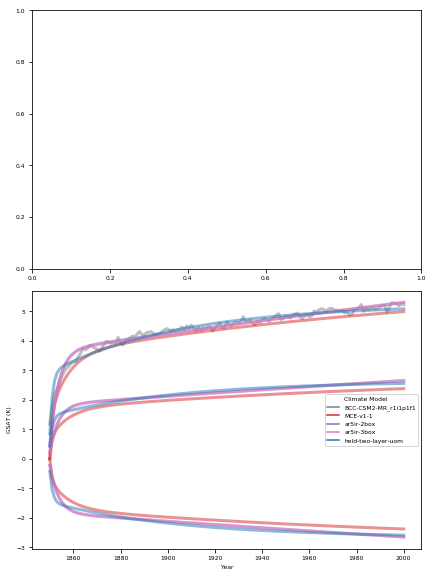

<IPython.core.display.Javascript object>

In [31]:
target_cmip6_models = [
    #     "AWI-CM-1-1-MR_r1i1p1f1",
    "BCC-CSM2-MR_r1i1p1f1",
    #     "BCC-ESM1_r1i1p1f1",
    #     #     "CAMS-CSM1-0_r1i1p1f1",  # missing data...
    #     "CanESM5_r1i1p1f1",
    #     "CanESM5_r1i1p2f1",
    #     "CanESM5_r10i1p1f1",
    #     "CESM2-WACCM_r1i1p1f1",
    #     "CESM2_r1i1p1f1",
    #     "CNRM-CM6-1_r1i1p1f2",
    #     "CNRM-ESM2-1_r1i1p1f2",
    #     "E3SM-1-0_r1i1p1f1",
    #     "EC-Earth3-Veg_r1i1p1f1",
    #     "FGOALS-g3_r1i1p1f1",
    #     #     "GFDL-CM4_r1i1p1f1",  # missing data...
    #     "GISS-E2-1-G_r1i1p1f1",
    #     "GISS-E2-1-H_r1i1p1f1",
    #     "GISS-E2-2-G_r1i1p1f1",
    #     #    "HadGEM3-GC31-LL_r1i1p1f1",  # missing data...
    #     "IPSL-CM6A-LR_r1i1p1f1",
    #     "IPSL-CM6A-LR_r1i1p1f2",
    #     "IPSL-CM6A-LR_r10i1p1f1",
    #     "MCM-UA-1-0_r1i1p1f2",
    #     #    "MIROC-ES2L_r1i1p1f1",  # missing data...
    #     "MIROC6_r1i1p1f1",
    #     "MPI-ESM1-2-HR_r1i1p1f1",
    #     #    "MRI-ESM2-0_r1i1p1f1",  # missing data...
    #     #     "NESM3_r1i1p1f1",  # missing data...
    #     "NorCPM1_r1i1p1f1",
    #     "NorESM2-LM_r1i1p1f1",
    #     "SAM0-UNICON_r1i1p1f1",
    #     "UKESM1-0-LL_r1i1p1f2",
]
rcmip_models = ["*"]
scenarios = [
    [
        "ssp119",
        "ssp126",
        "ssp245",
        "ssp370",
        "ssp434",
        "ssp460",
        "ssp585",
        "ssp534-over",
    ],
    ["abrupt-4xCO2", "abrupt-2xCO2", "abrupt-0p5xCO2"],
    ["abrupt-4xCO2", "abrupt-2xCO2", "abrupt-0p5xCO2"],
]
legends = [True, True, False, False, False]
variable_to_plot = "Surface Air Temperature Change"
yr_filters = [range(1850, 2101), range(1850, 1901), range(1900, 2501)]
yr_filters = [range(1850, 2101), range(1850, 2501)]


def put_cmip6_at_back(ax):
    for line in ax.get_lines():
        if line.get_linestyle() == "-":
            #             print(line.get_label())
            #             print(dir(line))
            line.set_alpha(0.5)
            line.set_lw(3)
            line.set_zorder(1)


for tcm in tqdm.tqdm_notebook(target_cmip6_models):
    target_cmip6_model_source_id = tcm.split("_")[0]
    target_cmip6_model_variant_label = tcm.split("_")[1]

    fig = plt.figure()
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    #     ax_top = fig.add_subplot(spec[0, :])
    #     ax_mid = fig.add_subplot(spec[1, 0])
    #     ax_bottom = fig.add_subplot(spec[1, 1], sharey=ax_mid)
    #     axes = [ax_top, ax_mid, ax_bottom]
    axes = [fig.add_subplot(spec[0, :]), fig.add_subplot(spec[1, :])]

    for i, (scen_filter, ax, legend, yr_filter) in enumerate(
        zip(scenarios, axes, legends, yr_filters)
    ):
        sns_df = []
        dashes_configs = {}
        color_map_climatemodel = {}

        climate_model_filter = "{}_{}".format(
            target_cmip6_model_source_id, target_cmip6_model_variant_label
        )
        dashes_configs[climate_model_filter] = ""
        color_map_climatemodel[climate_model_filter] = "tab:gray"

        pdf_cmip6 = db_cmip.filter(climatemodel=climate_model_filter)
        if i == 0:
            print(
                "scenarios available for {} are: {}".format(
                    climate_model_filter, pdf_cmip6["scenario"].unique()
                )
            )
            print("")

        pdf_cmip6 = pdf_cmip6.filter(scenario=scen_filter, variable=variable_to_plot)
        cmip6_year_filter = range(1850, 2301)
        if not pdf_cmip6.timeseries().empty:
            pdf_cmip6 = convert_scmdf_to_pyamdf_year_only(pdf_cmip6)
            min_year = pdf_cmip6["year"].min()
            if min_year != 1850:
                shift = 1850 - pdf_cmip6["year"].min()
                print("shifting CMIP data by {} years".format(shift))
                pdf_cmip6["year"] += shift

            sns_cmip6 = (
                pdf_cmip6.filter(region="World", year=yr_filter)
                .filter(scenario=["ssp245-*", "*gidden*"], keep=False)
                .data
            )
            sns_cmip6["climatemodel_label"] = sns_cmip6["climatemodel"]
            sns_df.append(sns_cmip6)
            cmip6_year_filter = pdf_cmip6["year"]

        try:
            pdf_rcmip = (
                convert_scmdf_to_pyamdf_year_only(
                    db_cmip_emulation.filter(
                        climatemodel_cmip6_target_source_id=target_cmip6_model_source_id,
                        climatemodel_cmip6_target_variant_label=[
                            target_cmip6_model_variant_label,
                            "all",
                        ],
                        scenario=scen_filter,
                        variable=variable_to_plot,
                        climatemodel=rcmip_models,
                        year=yr_filter,
                    )
                )
                .filter(year=cmip6_year_filter)
                .filter(scenario=["ssp245-*", "*gidden*"], keep=False)
            )
        except ValueError:
            print("no {} data for {}".format(scen_filter, climate_model_filter))
            continue

        sns_rcmip = pdf_rcmip.data
        sns_df.append(sns_rcmip)
        for cm in pdf_rcmip["climatemodel_label"].unique():
            if "MAGICC" in cm:
                dashes_configs[cm] = [1, 1]
                color_map_climatemodel[cm] = "tab:orange"
            if "hector" in cm:
                dashes_configs[cm] = [1, 1]
                color_map_climatemodel[cm] = "tab:green"
            if "MCE" in cm:
                dashes_configs[cm] = [5, 5]
                color_map_climatemodel[cm] = "tab:red"
            if "ar5ir2box" in cm:
                dashes_configs[cm] = [2, 1]
                color_map_climatemodel[cm] = "tab:purple"
            if "ar5ir3box" in cm:
                dashes_configs[cm] = [5, 2]
                color_map_climatemodel[cm] = "tab:pink"
            if "held" in cm:
                dashes_configs[cm] = [5, 4]
                color_map_climatemodel[cm] = "tab:blue"

        sns_df = pd.concat(sns_df, sort=True)
        sns_df["Scenario"] = sns_df["scenario"]
        sns_df["Climate Model"] = sns_df["climatemodel_label"]
        if pdf_rcmip["scenario"].unique().tolist()[0].startswith("ssp"):
            configs = {
                "hue": "Scenario",
                "hue_order": sorted(sns_df["scenario"].unique()),
                "style": "Climate Model",
                "palette": color_map_scenarios_hex,
            }
        else:
            configs = {
                "hue": "Climate Model",
                "hue_order": sorted(sns_df["climatemodel_label"].unique()),
                "units": "Scenario",
                "estimator": None,
                "palette": color_map_climatemodel,
                #                 "dashes": dashes_configs,
            }

        sns.lineplot(
            data=sns_df,
            x="year",
            y="value",
            ax=ax,
            linewidth=2,
            #             alpha=0.6,
            #             zorder=1,
            **configs,
        )
        if legend:
            clean_labels(
                ax,
                ignore=["Scenario", "Climate Model"]
                + sns_df["Scenario"].unique().tolist()
                + sns_df["Climate Model"].unique().tolist(),
            )
            ax.legend(loc="best")
        #             ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.5, 0.5, 0.5), ncol=1)
        else:
            ax.get_legend().remove()
        #             ax.set_title(scen_filter[0])

        put_cmip6_at_back(ax)
        ax.set_xlabel("Year")
        if i == 0:
            ax.set_ylabel("Global-mean surface air temperature change (GSAT) (K)")
        else:
            ax.set_ylabel("GSAT (K)")

    plt.tight_layout()
    plt.show()
    fig.savefig("emulation_x_chapter_box.pdf")

In [32]:
emulation_score_tables = {}
excluded_scenarios = [
    "historical",  # count as part of ssps
    "ssp245-*",
    "*gidden*",
    "1pctCO2-*",
    "abrupt-solp4p",
    "hist-*",
    "histSST-*",
    "G6solar",
    "esm*",
]

for tcm in tqdm.tqdm_notebook(target_cmip6_models, desc="Target CMIP6 Models"):
    # for tcm in tqdm.tqdm_notebook(["IPSL-CM6A-LR_r1i1p1f1"], desc="Target CMIP6 Models"):
    target_cmip6_model_source_id = tcm.split("_")[0]
    target_cmip6_model_variant_label = tcm.split("_")[1]
    climate_model_filter = "{}_{}".format(
        target_cmip6_model_source_id, target_cmip6_model_variant_label
    )

    emulation_db = db_cmip_emulation.filter(
        climatemodel_cmip6_target_source_id=target_cmip6_model_source_id,
        climatemodel_cmip6_target_variant_label=[
            target_cmip6_model_variant_label,
            "all",
        ],
    ).filter(scenario=excluded_scenarios, keep=False)

    cmip6_db = db_cmip.filter(climatemodel=climate_model_filter).filter(
        scenario=excluded_scenarios, keep=False
    )
    cmip6_db_n_scenarios = len(cmip6_db["scenario"].unique())

    scores_df = pd.DataFrame()
    for emulation_model in tqdm.tqdm_notebook(
        emulation_db["climatemodel"].unique(), desc="RCMIP Model", leave=False
    ):
        emulation_db_em = emulation_db.filter(climatemodel=emulation_model)
        for variable in tqdm.tqdm_notebook(
            cmip6_db["variable"].unique(), desc="Variable", leave=False
        ):
            cmip6_db_variable = cmip6_db.filter(variable=variable)
            emulation_db_em_variable = emulation_db_em.filter(
                variable=variable, scenario=cmip6_db_variable["scenario"].unique()
            )
            emulation_db_em_variable_n_scenarios = len(
                emulation_db_em_variable["scenario"].unique()
            )
            if np.equal(emulation_db_em_variable_n_scenarios, 0):
                print(
                    "no matching variables and scenarios for {} and {}".format(
                        emulation_model, climate_model_filter
                    )
                )
                continue

            # all our scenarios should start in 1850
            cmip6_db_variable_shifted = []
            for scenario in cmip6_db_variable["scenario"].unique():
                cmip6_db_variable_scenario = cmip6_db_variable.filter(scenario=scenario)
                if cmip6_db_variable_scenario["time"].min().year == 1850:
                    cmip6_db_variable_shifted.append(cmip6_db_variable_scenario)
                else:
                    shift = 1850 - cmip6_db_variable_scenario["time"].min().year
                    print(scenario)
                    print("shifting CMIP data by {} years".format(shift))
                    tmp = cmip6_db_variable_scenario.timeseries()
                    tmp.columns = tmp.columns.map(
                        lambda x: dt.datetime(x.year + shift, 7, 1)
                    )
                    cmip6_db_variable_shifted.append(tmp)

            cmip6_db_variable_shifted = df_append(cmip6_db_variable_shifted)

            ssps = emulation_db_em_variable.filter(scenario="ssp*")
            if not ssps.timeseries().empty:
                ssps = [s for s in ["scenario"]]
                if len(ssps) > 1:
                    # avoid double counting history
                    emulation_db_em_variable = emulation_db_em_variable.filter(
                        scenario=ssps[1:], year=range(1, 2016), keep=False
                    )
                    cmip6_db_variable_shifted = cmip6_db_variable_shifted.filter(
                        scenario=ssps[1:], year=range(1, 2016), keep=False
                    )

            emulation_db_em_variable = convert_scmdf_to_pyamdf_year_only(
                emulation_db_em_variable
            )
            cmip6_db_variable_shifted = convert_scmdf_to_pyamdf_year_only(
                cmip6_db_variable_shifted
            )

            diff_idx = {"variable", "region", "unit", "year"}
            em_df = emulation_db_em_variable.timeseries()
            em_df.columns.names = ["year"]
            em_df = em_df.unstack("scenario").stack("year")
            em_df.index = em_df.index.droplevel(list(set(em_df.index.names) - diff_idx))

            cmip_df = cmip6_db_variable_shifted.timeseries()
            cmip_df.columns.names = ["year"]
            cmip_df = cmip_df.unstack("scenario").stack("year")
            cmip_df.index = cmip_df.index.droplevel(
                list(set(cmip_df.index.names) - diff_idx)
            )

            rmse = (((em_df - cmip_df) ** 2).mean().mean()) ** 0.5

            label = "{} ({})".format(
                emulation_model, emulation_db_em_variable_n_scenarios
            )

            scores_df.loc[label, variable] = rmse

    emulation_score_tables[climate_model_filter] = {
        "no_scenarios": cmip6_db_n_scenarios,
        "scores": scores_df,
    }
#     break

Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


<IPython.core.display.Javascript object>

In [33]:
def rename_index_here(inv):
    if inv.startswith("MAGICC7.1.0.beta"):
        return "MAGICC7.1.0"
    if inv.startswith("MCE,v1-1"):
        return "MCE,v1-1"
    if inv.startswith("hector|62381e71"):
        return "hector|62381e71"
    if inv.startswith("ar5ir2box"):
        return "ar5ir2box"
    if inv.startswith("ar5ir3box"):
        return "ar5ir3box"
    if inv.startswith("held-two-layer-uom"):
        return "held-two-layer-uom"

    raise NotImplementedError(inv)


all_targets = []
counts = {}
for k, v in emulation_score_tables.items():
    tmp = v["scores"].copy()
    for iv in tmp.index:
        i_key = rename_index_here(iv)
        i_count = int(iv.split("(")[1].split(")")[0])
        if i_key not in counts:
            counts[i_key] = i_count
        else:
            counts[i_key] += i_count
    tmp.columns = [k]
    tmp.index = tmp.index.map(rename_index_here)
    all_targets.append(tmp)

all_targets = pd.concat(all_targets, sort=True, axis=1)
all_targets = all_targets.sort_index()
all_targets.index = all_targets.index.map(lambda x: "{} ({})".format(x, counts[x]))
all_targets.mean(axis=1).to_frame()

0
MCE,v1-1 (2)            0.209198
ar5ir2box (2)           0.125222
ar5ir3box (2)           0.125310
held-two-layer-uom (2)  0.128297

<IPython.core.display.Javascript object>

Add ECS of these configurations.

In [34]:
INFO_PATH = os.path.join("..", "..", "..", "data", "results", "phase-1")

<IPython.core.display.Javascript object>

In [35]:
model_of_interest = [
    ".*ar5ir.*",
    ".*hector.*v2.*",
    ".*held-two-layer-uom.*",
    ".*magicc.*",
    ".*mce-1.*v3.*",
]

info_files = Path(INFO_PATH).rglob("*.xlsx")
info_files = [
    str(p)
    for p in info_files
    if any([bool(re.match(m, str(p))) for m in model_of_interest]) and "$" not in str(p)
]

sorted(info_files)

['../../../data/results/phase-1/ar5ir/rcmip-data-submission-template-ar5ir.xlsx',
 '../../../data/results/phase-1/hector/rcmip_phase-1_hector_v2-0-0.xlsx',
 '../../../data/results/phase-1/held-two-layer-uom/rcmip-data-submission-template-held-two-layer.xlsx',
 '../../../data/results/phase-1/magicc7/rcmip-data-submission-template-magicc7.xlsx',
 '../../../data/results/phase-1/mce/rcmip_phase-1_mce-1_v3-0-0.xlsx']

<IPython.core.display.Javascript object>

In [36]:
undo_magicc_uppercase

{'BCC-CSM2-MR': 'BCC-CSM2-MR', 'BCC-ESM1': 'BCC-ESM1'}

<IPython.core.display.Javascript object>

In [37]:
ecs_df = []
for f in tqdm.tqdm_notebook(info_files):
    info_df = pd.read_excel(f, sheet_name="meta_model", skiprows=0).iloc[2:, :]
    if "held" in f:
        info_df["target_cmip6_model"] = info_df["ClimateModel"].apply(
            lambda x: "N/A"
            if "ECS-3K" in x
            else x.split("CMIP6-")[1].replace("-CALIB", "")
        )
    elif "mce" in f:
        info_df["target_cmip6_model"] = info_df[
            "Climate Model Configuration Label"
        ].apply(
            lambda x: "N/A"
            if "CMIP6" not in x
            else "{}_.*".format(x.split("CMIP6-")[1].replace("-CALIB", ""))
        )
    elif "ar5ir" in f:
        info_df["target_cmip6_model"] = info_df[
            "Climate Model Configuration Label"
        ].apply(
            lambda x: "N/A"
            if "CMIP6" not in x
            else x.split("CMIP6-")[1].replace("-CALIB", "")
        )
    elif "hector" in f:
        info_df["target_cmip6_model"] = info_df[
            "Climate Model Configuration Label"
        ].apply(
            lambda x: "N/A"
            if "CMIP6" not in x
            else "{}_.*".format(x.split("CMIP6-")[1].replace("-CALIB", ""))
        )
    elif "magicc" in f:

        def fix_magicc_uppercase(ins):
            try:
                model, variant = ins.split("_")
            except ValueError:
                return "N/A"

            if model in undo_magicc_uppercase:
                model = undo_magicc_uppercase[model]
            else:
                model = "none"

            return "_".join([model, variant.lower()])

        info_df["target_cmip6_model"] = info_df[
            "Climate Model Configuration Label"
        ].apply(fix_magicc_uppercase)

    info_df["climatemodel_label"] = info_df["ClimateModel"].apply(clean_label)
    info_df = info_df[["climatemodel_label", "target_cmip6_model", "ECS (K)"]]

    ecs_df.append(info_df)

ecs_df = pd.concat(ecs_df)
ecs_df.drop_duplicates()

climatemodel_label    target_cmip6_model  ECS (K)
2   held-two-layer-uom                   N/A  2.99909
3   held-two-layer-uom  BCC-CSM2-MR_r1i1p1f1  2.63165
4   held-two-layer-uom     BCC-ESM1_r1i1p1f1  2.31299
5   held-two-layer-uom  CESM2-WACCM_r1i1p1f1  2.55094
6   held-two-layer-uom        CESM2_r1i1p1f1  3.63315
..                 ...                   ...      ...
5      hector|62381e71         CNRM-CM6-1_.*  3.85744
6      hector|62381e71        CNRM-ESM2-1_.*  3.51001
7      hector|62381e71       IPSL-CM6A-LR_.*  3.07219
8      hector|62381e71                   N/A        3
9      hector|62381e71                   N/A      NaN

[141 rows x 3 columns]

<IPython.core.display.Javascript object>

In [38]:
def rename_index_here(inv):
    count = int(inv.split("(")[1].split(")")[0])
    inv = clean_label(inv)

    return "{} ({})".format(inv, count)


joint_table = []
for k, v in emulation_score_tables.items():
    tmp = v["scores"].copy()
    tmp.columns = ["{} ({})".format(k, v["no_scenarios"])]
    tmp.columns.name = "Target CMIP6 model"
    tmp.index = tmp.index.map(rename_index_here)
    tmp.index.names = ["RCMIP model"]
    tmp = tmp.stack("Target CMIP6 model").to_frame()
    tmp.columns = ["RMSE (K)"]
    for (rcmip_model_str, target_model_str), row in tmp.iterrows():
        target_model = target_model_str.split()[0]
        rcmip_model = rcmip_model_str.split()[0]
        tmp.loc[(rcmip_model_str, target_model_str), "ECS (K)"] = ecs_df.loc[
            (ecs_df["climatemodel_label"] == rcmip_model)
            & (
                ecs_df["target_cmip6_model"].apply(
                    lambda x: bool(re.match(x, target_model))
                )
            ),
            "ECS (K)",
        ].values.squeeze()

    tmp = tmp[["RMSE (K)", "ECS (K)"]]
    tmp["ECS (K)"] = tmp["ECS (K)"].astype(float)
    tmp = tmp.round(2)
    joint_table.append(tmp)

#     break

joint_table = (
    pd.concat(joint_table, sort=True, axis=0).reorder_levels(
        ["Target CMIP6 model", "RCMIP model"]
    )
    #     .reset_index()
)

caption = (
    "Emulation scores for RCMIP models. In parentheses we show "
    "the number of simulations available for each model variant."
)
with open("emulation-scores-table.tex", "w") as f:
    f.write(
        joint_table.to_latex(longtable=True).replace(
            "\\toprule\n",
            "\\caption{\\normalsize{"
            + caption
            + "}}\n\\label{tab:emulation-scores} \\\\\n"
            "\\toprule\n",
        )
    )

joint_table

ECS (K)  RMSE (K)
Target CMIP6 model       RCMIP model                              
BCC-CSM2-MR_r1i1p1f1 (6) MCE-v1-1 (2)               2.90      0.21
                         ar5ir-2box (2)             7.35      0.13
                         ar5ir-3box (2)             7.78      0.13
                         held-two-layer-uom (2)     2.63      0.13

<IPython.core.display.Javascript object>